#1. Load the dataset, PRSA_Data.csv, into memory.

In [1]:
import pandas as pd
import glob
df = pd.read_csv('data.csv',sep = ',')

allFiles = glob.glob("/content/data/*.csv")
dataFrames = []
for i in allFiles:
    df = pd.read_csv(i, index_col=None, header=0)
    dataFrames.append(df)
data = pd.concat(dataFrames)

#drop the number
data.drop(["No"], axis=1, inplace=True)
data.rename(columns = {'year': 'Year',
                       'month': 'Month',
                       'day': "Day",
                       'hour': 'Hour',
                       'pm2.5': 'PM2.5',
                       'DEWP': 'DewP',
                       'TEMP': 'Temp',
                       'PRES': 'Press',
                       'RAIN': 'Rain',
                       'wd': 'WinDir',
                       'WSPM': 'WinSpeed',
                       'station': 'Station'}, inplace = True)
data

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinDir,WinSpeed,Station
0,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin


#2. Clean the data and check missing values for this dataset.

In [2]:
import numpy as np
# fill the null values in numerical columns with average specific to certain column


unique_Month = pd.unique(data.Month) #get all unique months in a list

temp_data = data.copy()  # set temp_data variable to avoid losing real data
columns = ["PM2.5", 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed']
for c in unique_Month:

    #this is the power of boolean indexing in pandas
    # creates boolean mask Month filter of true and false months
    Month_filtre = temp_data.Month == c
    # filter data by Month selecting only matching the month C
    fitered_data = temp_data[Month_filtre]

    # loop through columns starting with PM2.5
    for s in columns:
        #get PM2.5 from the filtered_data (aka the month) and round to 2 decimal places
        mean = np.round(np.mean(fitered_data[s]), 2)
        if ~np.isnan(mean): # if there if average specific to Month
            fitered_data[s] = fitered_data[s].fillna(mean)
            #print(f"Missing Value in {s} column fill with {mean} when Month:{c}")
        else: # find average for all data if no average in specific to Month.
        #in other words there is no data available for that month
            all_data_mean = np.round(np.mean(data[s]),2)
            fitered_data[s] = fitered_data[s].fillna(all_data_mean)
            #print(f"Missing Value in {s} column fill with {all_data_mean}")
    # Synchronize data filled with missing values in PM2.5 to data temporary
    temp_data[Month_filtre] = fitered_data

data = temp_data.copy()


<ipython-input-2-60dd46916a03>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitered_data[s] = fitered_data[s].fillna(mean)


In [3]:
data.dtypes

Year          int64
Month         int64
Day           int64
Hour          int64
PM2.5       float64
PM10        float64
SO2         float64
NO2         float64
CO          float64
O3          float64
Temp        float64
Press       float64
DewP        float64
Rain        float64
WinDir       object
WinSpeed    float64
Station      object
dtype: object

In [4]:
data.isnull().sum(axis = 0)

Year           0
Month          0
Day            0
Hour           0
PM2.5          0
PM10           0
SO2            0
NO2            0
CO             0
O3             0
Temp           0
Press          0
DewP           0
Rain           0
WinDir      1822
WinSpeed       0
Station        0
dtype: int64

#3. Convert all categorical variables to numerical values.


In [5]:
catFeatures = ['WinDir','Station']
data[catFeatures].describe(include='all').loc['unique',:]
#avoid multicollinearity issues in regression models because the information about the dropped category can be inferred from the absence of the other categories
factors = pd.get_dummies(data[catFeatures],drop_first=True)
data = data.drop(catFeatures,axis=1)
data = pd.concat([data,factors], axis = 1)
data.head()

,Year,Month,Day,Hour,PM2.5,PM10,SO2,NO2,CO,O3,...,Station_Dingling,Station_Dongsi,Station_Guanyuan,Station_Gucheng,Station_Huairou,Station_Nongzhanguan,Station_Shunyi,Station_Tiantan,Station_Wanliu,Station_Wanshouxigong
0,2013,3,1,0,6.0,18.0,5.0,60.12,800.00,88.00,...,0,0,0,1,0,0,0,0,0,0
1,2013,3,1,1,6.0,15.0,5.0,60.12,800.00,88.00,...,0,0,0,1,0,0,0,0,0,0
2,2013,3,1,2,5.0,18.0,28.0,60.12,700.00,52.00,...,0,0,0,1,0,0,0,0,0,0
3,2013,3,1,3,6.0,20.0,6.0,60.12,1310.23,51.04,...,0,0,0,1,0,0,0,0,0,0
4,2013,3,1,4,5.0,17.0,5.0,60.12,600.00,73.00,...,0,0,0,1,0,0,0,0,0,0


In [6]:
'''
data['Date'] = pd.to_datetime(data[['Year','Month','Day']])
data.tail()
'''

"\ndata['Date'] = pd.to_datetime(data[['Year','Month','Day']])\ndata.tail()\n"

In [7]:
data.dtypes

Year                       int64
Month                      int64
Day                        int64
Hour                       int64
PM2.5                    float64
PM10                     float64
SO2                      float64
NO2                      float64
CO                       float64
O3                       float64
Temp                     float64
Press                    float64
DewP                     float64
Rain                     float64
WinSpeed                 float64
WinDir_ENE                 uint8
WinDir_ESE                 uint8
WinDir_N                   uint8
WinDir_NE                  uint8
WinDir_NNE                 uint8
WinDir_NNW                 uint8
WinDir_NW                  uint8
WinDir_S                   uint8
WinDir_SE                  uint8
WinDir_SSE                 uint8
WinDir_SSW                 uint8
WinDir_SW                  uint8
WinDir_W                   uint8
WinDir_WNW                 uint8
WinDir_WSW                 uint8
Station_Ch

In [8]:
np.round(data[columns].describe(),decimals=2)

,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinSpeed
count,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00,420768.00
mean,79.77,104.61,15.82,50.61,1232.98,57.22,13.53,1010.75,2.48,0.06,1.73
std,80.01,91.09,21.46,34.66,1136.59,56.00,11.44,10.47,13.80,0.82,1.25
min,2.00,2.00,0.29,1.03,100.00,0.21,-19.90,982.40,-43.40,0.00,0.00
25%,21.00,36.00,3.00,24.00,500.00,12.00,3.10,1002.30,-8.90,0.00,0.90
50%,57.00,83.00,7.14,44.00,900.00,45.00,14.50,1010.40,3.00,0.00,1.40
75%,109.00,144.00,20.00,70.00,1500.00,82.00,23.20,1019.00,15.10,0.00,2.20
max,999.00,999.00,500.00,290.00,10000.00,1071.00,41.60,1042.80,29.10,72.50,13.20


In [9]:
np.round(data[columns].corr(),decimals=2)

,PM2.5,PM10,SO2,NO2,CO,O3,Temp,Press,DewP,Rain,WinSpeed
PM2.5,1.00,0.88,0.48,0.66,0.77,-0.15,-0.13,0.02,0.11,-0.01,-0.27
PM10,0.88,1.00,0.46,0.65,0.68,-0.11,-0.10,-0.02,0.07,-0.03,-0.18
SO2,0.48,0.46,1.00,0.49,0.53,-0.17,-0.32,0.23,-0.27,-0.04,-0.11
NO2,0.66,0.65,0.49,1.00,0.69,-0.47,-0.28,0.18,-0.04,-0.04,-0.39
CO,0.77,0.68,0.53,0.69,1.00,-0.32,-0.33,0.20,-0.07,-0.01,-0.29
O3,-0.15,-0.11,-0.17,-0.47,-0.32,1.00,0.60,-0.45,0.32,0.02,0.29
Temp,-0.13,-0.10,-0.32,-0.28,-0.33,0.60,1.00,-0.81,0.82,0.04,0.03
Press,0.02,-0.02,0.23,0.18,0.20,-0.45,-0.81,1.00,-0.75,-0.06,0.07
DewP,0.11,0.07,-0.27,-0.04,-0.07,0.32,0.82,-0.75,1.00,0.09,-0.30
Rain,-0.01,-0.03,-0.04,-0.04,-0.01,0.02,0.04,-0.06,0.09,1.00,0.02


In [10]:
import seaborn as sns
import warnings
'''
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
sns.pairplot(data[columns],diag_kind='kde')
'''

"\nwarnings.filterwarnings('ignore')\nwarnings.simplefilter('ignore')\nsns.pairplot(data[columns],diag_kind='kde')\n"

#4. Split the data into 80% of training and 20% of the test dataset.

In [11]:
X = data.drop('PM2.5',axis = 1)
y = data['PM2.5']

from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = .2, random_state = 2021)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (336614, 40)
y_train: (336614,)
X_test: (84154, 40)
y_test: (84154,)


#5. Preprocess the data using the normalization method to convert all features into the range of [0,1]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#6. Build a neuron network with two hidden layers of 20 and 10 neurons to forecast PM2.5 using all other features and TensorFlow. Does it overfit or underfit the data? Please justify your answer.

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(layers.Dense(100,activation='relu'))
model.add(layers.Dense(20,activation='relu'))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam',loss='mse')

In [14]:
%%time
tf.random.set_seed(1)
history = model.fit(x=X_train,y=y_train,batch_size=64,epochs=100,
                    validation_data=(X_test,y_test))

Epoch 1/100
5260/5260 [==============================] - 10s 2ms/step - loss: 1407.7550 - val_loss: 796.8101
Epoch 2/100
5260/5260 [==============================] - 9s 2ms/step - loss: 718.1393 - val_loss: 682.8460
Epoch 3/100
5260/5260 [==============================] - 9s 2ms/step - loss: 645.6052 - val_loss: 635.4385
Epoch 4/100
5260/5260 [==============================] - 8s 2ms/step - loss: 610.6824 - val_loss: 605.4755
Epoch 5/100
5260/5260 [==============================] - 12s 2ms/step - loss: 589.4995 - val_loss: 586.3615
Epoch 6/100
5260/5260 [==============================] - 13s 2ms/step - loss: 573.5170 - val_loss: 578.1354
Epoch 7/100
5260/5260 [==============================] - 10s 2ms/step - loss: 559.3907 - val_loss: 559.3899
Epoch 8/100
5260/5260 [==============================] - 10s 2ms/step - loss: 546.5641 - val_loss: 548.3376
Epoch 9/100
5260/5260 [==============================] - 9s 2ms/step - loss: 536.0037 - val_loss: 558.2900
Epoch 10/100
5260/5260 [=======

In [15]:
trainhist = pd.DataFrame(history.history)
trainhist['epoch'] = history.epoch
trainhist.tail()

,loss,val_loss,epoch
95,356.470245,402.724396,95
96,356.443939,388.090851,96
97,356.017883,383.278442,97
98,354.760254,389.357025,98
99,354.991974,390.829254,99


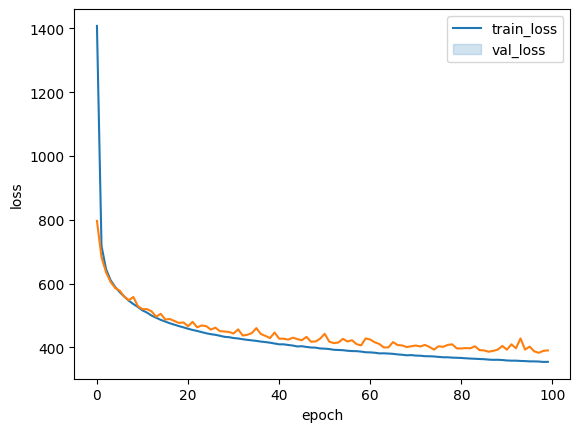

In [16]:
import matplotlib.pyplot as plt
sns.lineplot(x='epoch',y='loss',data=trainhist)
sns.lineplot(x='epoch',y='val_loss',data=trainhist)
plt.legend(labels=['train_loss','val_loss'])

#7. Training loss underfit the data. Looking at the chart, the loss is below 400 after 100 epochs when the val_loss is above 400.

3ms/step - loss: 348.4549 - val_loss: 378.0112

Tune the model using the following hyperparameters using keras-tuner:
- First hidden layer with units between 20 and 50 with a step size of 5
- Second hidden layer with units between 5 and 10 with a step size of 1
- The dropout rate for both hidden layer is between 0.2 and 0.8 with a step size of 0.1

Please recommend the optimal model and specify the hyperparameters.

In [17]:
import sys
if('keras-tuner' not in sys.modules):
  !pip install -q -U keras-tuner
import kerastuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.2 MB/s eta 0:00:00


<ipython-input-17-69496f72a099>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


In [18]:
from tensorflow.keras.layers import Dropout

def model_builder(hp):
  model = keras.Sequential()
  model.add(layers.Dense(100,activation='relu'))

  #initializing units and dropout
  hp_units1 = hp.Int('units1', min_value = 20, max_value = 50, step = 5)
  hp_units2 = hp.Int('units2', min_value = 5, max_value = 10, step = 1)
  hp_dropout1 = hp.Float('rate', min_value = 0.2, max_value = 0.8, step = 0.1)
  hp_dropout2 = hp.Float('rate2', min_value = 0.2, max_value = 0.8, step = 0.1)
  # first hidden layer
  model.add(layers.Dense(units = hp_units1, activation = 'relu'))
  model.add(Dropout(rate = hp_dropout1))

  # second hidden layer
  model.add(layers.Dense(units = hp_units2, activation = 'relu'))
  model.add(Dropout(rate = hp_dropout2))


  # output layer has one and only one neuron
  model.add(layers.Dense(1))

 # Tune the learning rate for the optimizer
 # Search the lerning rate from 0.01, 0.001, or 0.0001.
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = 'mse',
                metrics = [tf.keras.metrics.MeanSquaredError()])

  return model

In [19]:
tuner = kerastuner.Hyperband(model_builder, #Specify the model
                     objective = 'val_loss', #Specify the objective function
                     max_epochs = 100, #Specify the maximum epochs
                     directory = 'my_dir', #Specify the file path
                     project_name = 'tuningRegression')

In [20]:
import IPython
#Clear all the training outputs
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [21]:
tuner.search(X_train, y_train, epochs = 100, validation_data = (X_test,y_test), callbacks = [ClearTrainingOutput()])

Trial 3 Complete [00h 00m 41s]
val_loss: 1295.5006103515625

Best val_loss So Far: 1295.5006103515625
Total elapsed time: 00h 02m 14s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
30                |30                |units1
8                 |5                 |units2
0.6               |0.5               |rate
0.7               |0.3               |rate2
0.0001            |0.0001            |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 1945/10520 [====>.........................] - ETA: 11s - loss: 11768.5713 - mean_squared_error: 11768.5713

KeyboardInterrupt: ignored

In [27]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
#Use f-strings to format the outputs
print(f"""
The optimal number of units in the input layer =  {best_hps.get('units1')}.
The optimal number of units in the input layer =  {best_hps.get('units2')}.
The optimal dropout rate in the input layer = {best_hps.get('rate')}
      The optimal dropout rate in the input layer = {best_hps.get('rate2')}
The optimal learning rate for the optimizer of Adam = {best_hps.get('learning_rate')}.
""")


The optimal number of units in the input layer =  30.
The optimal number of units in the input layer =  5.
The optimal dropout rate in the input layer = 0.5
      The optimal dropout rate in the input layer = 0.30000000000000004
The optimal learning rate for the optimizer of Adam = 0.0001.



In [28]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test,y_test))

Epoch 1/100
10520/10520 [==============================] - 20s 2ms/step - loss: 6387.5259 - mean_squared_error: 6387.5259 - val_loss: 2065.7109 - val_mean_squared_error: 2065.7109
Epoch 2/100
10520/10520 [==============================] - 18s 2ms/step - loss: 3855.2266 - mean_squared_error: 3855.2266 - val_loss: 1751.1799 - val_mean_squared_error: 1751.1799
Epoch 3/100
10520/10520 [==============================] - 19s 2ms/step - loss: 3642.9548 - mean_squared_error: 3642.9548 - val_loss: 1667.6510 - val_mean_squared_error: 1667.6510
Epoch 4/100
10520/10520 [==============================] - 18s 2ms/step - loss: 3305.1738 - mean_squared_error: 3305.1738 - val_loss: 1363.2532 - val_mean_squared_error: 1363.2532
Epoch 5/100
10520/10520 [==============================] - 19s 2ms/step - loss: 2919.9131 - mean_squared_error: 2919.9131 - val_loss: 1285.7024 - val_mean_squared_error: 1285.7024
Epoch 6/100
10520/10520 [==============================] - 18s 2ms/step - loss: 2847.9004 - mean_squ

loss: 1689.5347 - mean_squared_error: 1689.5347 - val_loss: 816.8865 - val_mean_squared_error: 816.8865

In [29]:
trainhist = pd.DataFrame(history.history)
trainhist['epoch'] = history.epoch
trainhist.tail()


,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
95,1597.392822,1597.392822,739.432373,739.432373,95
96,1594.285645,1594.285645,728.863403,728.863403,96
97,1594.425537,1594.425537,697.998047,697.998047,97
98,1590.654419,1590.654419,739.871094,739.871094,98
99,1584.071777,1584.071777,737.486023,737.486023,99


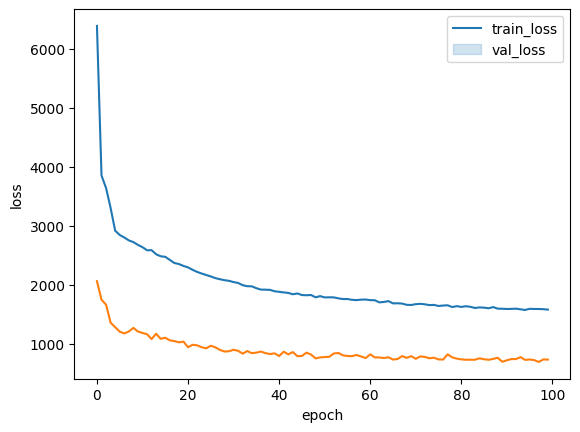

In [30]:
sns.lineplot(x='epoch',y='loss',data=trainhist)
sns.lineplot(x='epoch',y='val_loss',data=trainhist)
plt.legend(labels=['train_loss','val_loss'])

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = model.predict(X_test)
'The mean square error is {0:.4f}'.format(mean_squared_error(y_test,y_pred))

2630/2630 [==============================] - 3s 974us/step


'The mean square error is 737.4859'

In [32]:
'The root of mean square error is {0:.4f}'.format(mean_squared_error(y_test,y_pred,squared = False))

'The root of mean square error is 27.1567'

In [33]:
'The mean absolute error is {0:.4f}'.format(mean_absolute_error(y_test,y_pred))

'The mean absolute error is 18.8609'

#8. Build a neuron network with two hidden layers of 20 and 10 neurons to forecast PM2.5 using all other features and PyTorch. Does it overfit or underfit the data? Please justify your answer.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
X_train = torch.tensor(X_train.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32).reshape(-1,1))

In [35]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
#specify the number of neuron for the first layer
hidden_size = [100, 20, 10]
print(input_size)
print(output_size)

#convert numpy to tensor from_numpy
X_test = torch.from_numpy(X_test.astype(np.float32))

40
1


In [36]:
# define the child module class derivated from parent class of torch.nn.Module)
class LinearRegressionModel(torch.nn.Module):
    #define the constructor
    def __init__(self, input_size,  hidden_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size[0])
        self.hidden2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.hidden3 = torch.nn.Linear(hidden_size[1], hidden_size[2])
        self.predict = torch.nn.Linear(hidden_size[2], output_size)
    #overife the forward function in this child class
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        y_pred = self.predict(x)
        return y_pred

In [37]:
model = LinearRegressionModel(input_size, hidden_size,  output_size)

In [38]:
l = nn.MSELoss()

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [40]:
%%time
from sklearn.metrics import mean_squared_error
#fix the random seeds for troch and np
torch.manual_seed(1)
np.random.seed(0)


#set the number of epochs

num_epochs = 100

train_loss = [None]*num_epochs
valadition_loss = [None]*num_epochs
for epoch in range(num_epochs):
    #forward pass
    y_pred = model(X_train.requires_grad_())

    #calculate the loss
    loss= l(y_pred, y_train)
    #Set the gradients to be zero
    optimizer.zero_grad()

    #backward pass: calculate gradients
    loss.backward()

    #update the weights
    optimizer.step()

    #Stop tracking the gradient by calling detach since we don't use it anymore
    y_pred = model(X_test).detach().numpy()
    val_loss = mean_squared_error(y_test,y_pred)
    train_loss[epoch] = loss.item()
    valadition_loss[epoch] = val_loss
    if epoch % 10 == 0:
        print('epoch {0}, loss = {1:.4f} and val_loss = {2:.4f}'.format(epoch, loss.item(), val_loss))


epoch 0, loss = 12776.6572 and val_loss = 12650.4599
epoch 10, loss = 6284.7588 and val_loss = 6462.8620
epoch 20, loss = 4229.6733 and val_loss = 4229.3920
epoch 30, loss = 2161.6277 and val_loss = 2099.7600
epoch 40, loss = 1635.6909 and val_loss = 1608.7393
epoch 50, loss = 1331.2770 and val_loss = 1307.3684
epoch 60, loss = 1199.1288 and val_loss = 1192.0006
epoch 70, loss = 1114.0251 and val_loss = 1115.9006
epoch 80, loss = 1050.6469 and val_loss = 1059.8263
epoch 90, loss = 1006.2714 and val_loss = 1017.7471
CPU times: user 56.2 s, sys: 18.6 s, total: 1min 14s
Wall time: 1min 14s


In [41]:
trainhist = pd.DataFrame({'train_loss': train_loss, 'val_loss': valadition_loss, 'epoch':np.arange(num_epochs)})
trainhist.tail()

,train_loss,val_loss,epoch
95,989.163086,1002.743607,95
96,985.800171,1000.206476,96
97,982.845947,997.649021,97
98,980.049255,994.718289,98
99,977.083069,992.283895,99


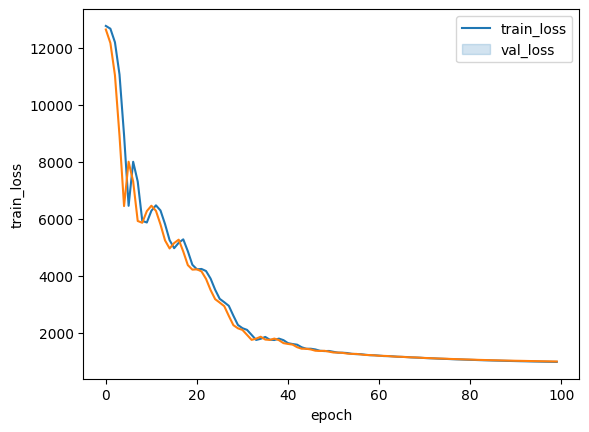

In [42]:
sns.lineplot(x='epoch', y ='train_loss', data =trainhist)
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
plt.legend(labels=['train_loss', 'val_loss'])